In [1]:
from pathlib import Path
import shutil

import amici
from amici.petab_import import import_petab_problem
from amici.plotting import plotObservableTrajectories
import matplotlib.pyplot as plt
from more_itertools import one
import numpy as np
import pandas as pd
import petab
from petab.C import (
    TIME,
    ESTIMATE,
    MEASUREMENT,
    NOMINAL_VALUE,
)
import yaml2sbml

# Optimization
import pypesto.engine
import pypesto.objective
import pypesto.optimize
import pypesto.petab
import pypesto.visualize

# Optimal control
import petab_control
import petab_control.problem
from petab_control.constants import (
    CONTROL_TIMECOURSE_ID,
    PERIODS_RESULTS,
)
from petab_control.problem import (
    LLH,
    SLLH,
)

# Timecourse
import petab_timecourse
from petab_timecourse import Timecourse

# Helpers
def plot(
    rdata,
    model,
    estimate_petab_problem,
    control_petab_problem = None,
):
    fig, ax = plt.subplots()
    ax.scatter(
        estimate_petab_problem.measurement_df[petab.C.TIME],
        estimate_petab_problem.measurement_df[petab.C.MEASUREMENT],
        label='Real measurements for fitting.',
        color='blue',
    )
    if control_petab_problem is not None:
        ax.scatter(
            control_petab_problem.measurement_df[petab.C.TIME],
            control_petab_problem.measurement_df[petab.C.MEASUREMENT],
            label='Target measurements for control.',
            color='orange',
        )
    plotObservableTrajectories(rdata, model=model, ax=ax)
    #ax.axvline(1)
    #ax.axvline(20)
    #ax.axhline(0.5)
    ax.axvspan(0, 20, facecolor='blue', alpha=0.1)
    ax.axvspan(20, 100, facecolor='orange', alpha=0.1)
    ax.set_ylim(0,1)
    return ax, rdata

# Plotted time
end_time = 100

# The same optimizer, optimization engine, and number of starts is
# used for both estimation and optimal control, for this toy model.
optimizer = pypesto.optimize.FidesOptimizer()
#engine = pypesto.engine.MultiProcessEngine()
engine = pypesto.engine.SingleCoreEngine()

n_starts = 8

In [2]:
# Setup PEtab problem
input_path = Path('input') / 'optimize_then_control'
output_path = Path('output') / 'optimize_then_control'
petab_output_path = output_path / 'petab'
petab_output_path.mkdir(parents=True, exist_ok=True)

if True:
    shutil.rmtree(petab_output_path)
    shutil.copytree(input_path / 'petab', petab_output_path)
    yaml2sbml.yaml2sbml(
        str(input_path / 'model.yaml'),
        str(petab_output_path / 'estimate' / 'model.xml'),
    )

estimate_petab_problem = petab_timecourse.Problem.from_yaml(
    petab_output_path / 'estimate' / 'petab_problem.yaml',
    timecourse_file=petab_output_path / 'estimate' / 'timecourse.tsv',
)

# Optimize estimate problem to estimate patient-specific parameters
## Setup
model_output_path = output_path / 'models'
estimate_model_output_path = model_output_path / 'estimate'

In [3]:
# Setup PEtab control problem
control_petab_output_path = output_path / 'control_petab'
control_petab_output_path.mkdir(parents=True, exist_ok=True)

control_problem = petab_control.Problem.from_yaml(
    yaml_path=input_path / 'petab' / 'control' / 'petab_control_problem.yaml',
)

In [4]:
from petab_timecourse.amici import collect_x, collect_sx, collect_t, remove_duplicates

from petab_timecourse.simulator import AmiciSimulator

model_settings = {
    'setAlwaysCheckFinite': True,
}

solver_settings = {
    'setAbsoluteTolerance': 1e-8,
    'setRelativeTolerance': 1e-6,
    'setSensitivityOrder': amici.SensitivityOrder.first,
    'setSensitivityMethod': amici.SensitivityMethod.forward,
}

estimated_parameters = {
    'decay': 0.010658565449186457,
    'substrate0': 0.8109781420306815,
}
# FIXME
estimated_parameters = {
    'decay': 1.0,
    'substrate0': 0.8109781420306815,
}

default_problem_parameters = {
    **estimated_parameters,
    'influx': 0,
}

control_problem.setup_simulator(
    simulator_class=AmiciSimulator,
    petab_problem=estimate_petab_problem,
    timecourse_id='timecourse1',
    default_problem_parameters=default_problem_parameters,
    model_settings=model_settings,
    solver_settings=solver_settings,
)

In [5]:
problem_parameter_ids = [
    f'influx_{id_}'
    for id_ in [
        '00',
        '20',
        '40',
        '60',
        '80',
    ]
]

problem_parameters = {
    'influx_00': 0.3,
    'influx_20': 0.1,
    'influx_40': 0.3,
    'influx_60': 0.5,
    'influx_80': 0.8,
}

problem_parameters = {
    problem_parameter_id: 0.1
    for problem_parameter_id in problem_parameter_ids
}

problem_parameters = {
    'influx_00': 0.3,
    'influx_20': 0.1,
    'influx_40': 0.3,
    'influx_60': 0.5,
    'influx_80': 0.8,
}

#problem_parameters = {
#    parameter_id: np.log10(parameter_value)
#    for parameter_id, parameter_value in problem_parameters.items()
#}

print(problem_parameters)

{'influx_00': 0.3, 'influx_20': 0.1, 'influx_40': 0.3, 'influx_60': 0.5, 'influx_80': 0.8}


In [6]:
# Run once to set timepoints in edata objects
# The next cell adds fake timepoints
# Unnecessary as the time period information, which is used to
# choose fake timepoints, is in the Timecourse object.
_ = control_problem.simulate(problem_parameters=problem_parameters)

In [7]:
from petab_timecourse.amici import add_output_timepoints_if_missing
if True:
    # Fake timepoints for more simulation output
    for edata, period in zip(
        control_problem.simulator.amici_edata_periods,
        control_problem.simulator.timecourse.periods,
    ):
        current_timepoints = edata.getTimepoints()
        add_output_timepoints_if_missing(
            amici_edata=edata,
            timepoints=np.linspace(current_timepoints[0], current_timepoints[-1], 101)
        )

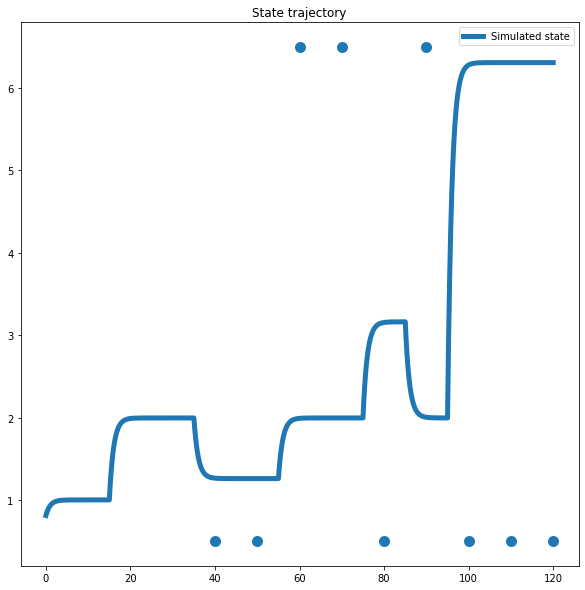

In [8]:
results = control_problem.simulate(problem_parameters=problem_parameters)

x_ = collect_x(results[PERIODS_RESULTS])
sx_ = collect_sx(results[PERIODS_RESULTS])
t_ = collect_t(results[PERIODS_RESULTS])

T, X, SX = remove_duplicates(t_, x_, sx_)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(T, X, lw=5, label='Simulated state')
ax.legend()
ax.set_title('State trajectory')

mT = control_problem.simulator.petab_problem.measurement_df[TIME]
mX = control_problem.simulator.petab_problem.measurement_df[MEASUREMENT]

ax.scatter(mT, mX, lw=5, label='Measured state')

In [9]:
import copy

estimated_parameter_id = 'influx_40'
estimated_parameter_id_amici = 'influx'

estimated_parameter_period_indices = control_problem.simulator_control_parameters[estimated_parameter_id]['periods']

def simulate(p, problem_parameters=problem_parameters):
    """
    if len(p) == 1:
        problem_parameters[estimated_parameter_id] = one(p)
        results = control_problem.simulate(problem_parameters=problem_parameters)
    else:
        problem_parameters0 = copy.deepcopy(problem_parameters)
        for parameter_index, parameter_id in enumerate(problem_parameters):
            problem_parameters[parameter_id] = p[parameter_index]
        results = control_problem.simulate(problem_parameters=problem_parameters)
        problem_parameters = copy.deepcopy(problem_parameters0)
    """
    problem_parameters[estimated_parameter_id] = one(p)
    results = control_problem.simulate(problem_parameters=problem_parameters)
    
    nllh = -results[LLH]
    
    sllh = 0
    for period in estimated_parameter_period_indices:
        sllh += results[PERIODS_RESULTS][period][SLLH][estimated_parameter_id_amici]
    
    snllh = -sllh
    
    return nllh, snllh

def fun(p):
    return simulate(p)[0]

def grad(p):
    return simulate(p)[1]

In [10]:
import scipy.optimize

res = scipy.optimize.minimize(
    fun=fun,
    x0=[8],
    method='l-bfgs-b',
    jac=grad,
    bounds=[(0.0001, 10)],
)

In [11]:
print(res)
problem_parameters[estimated_parameter_id] = one(res.x)
print(problem_parameters)

      fun: 63.08936834214841
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.41366022])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 6
     njev: 51
   status: 0
  success: True
        x: array([0.8135848])
{'influx_00': 0.3, 'influx_20': 0.1, 'influx_40': 0.8135847960361728, 'influx_60': 0.5, 'influx_80': 0.8}


{'influx_00': 0.3, 'influx_20': 0.1, 'influx_40': 0.8135847960361728, 'influx_60': 0.5, 'influx_80': 0.8}


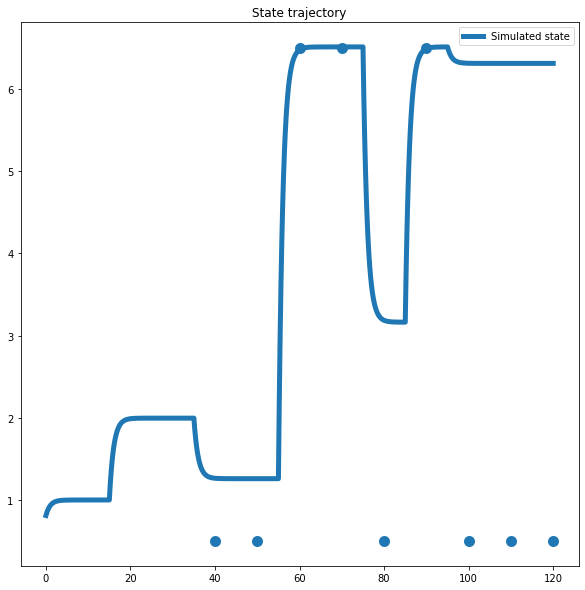

In [12]:
print(problem_parameters)
results = control_problem.simulate(problem_parameters=problem_parameters)

x_ = collect_x(results[PERIODS_RESULTS])
sx_ = collect_sx(results[PERIODS_RESULTS])
t_ = collect_t(results[PERIODS_RESULTS])

T, X, SX = remove_duplicates(t_, x_, sx_)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(T, X, lw=5, label='Simulated state')
ax.legend()
ax.set_title('State trajectory')

mT = control_problem.simulator.petab_problem.measurement_df[TIME]
mX = control_problem.simulator.petab_problem.measurement_df[MEASUREMENT]

#ax.set_yscale('log')

ax.scatter(mT, mX, lw=5, label='Measured state');

In [13]:
"""
data = {
    'parameter_value': [],
    'nllh': [],
    'snllh': [],
    'nllh2': [],
    'snllh2': [],
}

for parameter_value in sorted(set([*np.linspace(0, 10, 11), *np.linspace(0.9, 1.1, 21)])):
    problem_parameters[estimated_parameter_id] = parameter_value
    results = control_problem.simulate(problem_parameters=problem_parameters)
    nllh = -results[LLH]
    snllh = -results[SLLH][estimated_parameter_id]
    data['parameter_value'].append(parameter_value)
    data['nllh'].append(nllh)
    data['snllh'].append(snllh)

    nllh2, snllh2 = simulate([parameter_value])
    data['nllh2'].append(nllh2)
    data['snllh2'].append(snllh2)

df = pd.DataFrame(data=data)

df['nllh_diff'] = df['nllh2'] - df['nllh']
df['snllh_diff'] = df['snllh2'] - df['snllh']

print(df)
"""

"\ndata = {\n    'parameter_value': [],\n    'nllh': [],\n    'snllh': [],\n    'nllh2': [],\n    'snllh2': [],\n}\n\nfor parameter_value in sorted(set([*np.linspace(0, 10, 11), *np.linspace(0.9, 1.1, 21)])):\n    problem_parameters[estimated_parameter_id] = parameter_value\n    results = control_problem.simulate(problem_parameters=problem_parameters)\n    nllh = -results[LLH]\n    snllh = -results[SLLH][estimated_parameter_id]\n    data['parameter_value'].append(parameter_value)\n    data['nllh'].append(nllh)\n    data['snllh'].append(snllh)\n\n    nllh2, snllh2 = simulate([parameter_value])\n    data['nllh2'].append(nllh2)\n    data['snllh2'].append(snllh2)\n\ndf = pd.DataFrame(data=data)\n\ndf['nllh_diff'] = df['nllh2'] - df['nllh']\ndf['snllh_diff'] = df['snllh2'] - df['snllh']\n\nprint(df)\n"